## Simple XGBoost tutorial


XGBoost (eXtreme Gradient Boosting) is a machine learning algorithm that uses an ensemble of decision trees and gradient boosting to make predictions.
It is very powerful and scalable, frequently among the best methods you can use in machine learning competitions.

### Brief description
XGBoost relies on ensemble learning via boosting, meaning that its purpose is to combine the predictive power of an arbitrary number of models. The result is one model whose output is an aggregation of the output of all (base) models. The base models can be of the same type or not. 

Bagging and Boosting are common methods to build ensemble learners but they differ in some crucial aspecs.

#### Bagging (bootstrap aggregating)
Decision trees are one of the most easily interpretable models but they exhibit highly variable behavior. To stabilize them a common solution is to combine bootstrap (training a model on a random sample of the data) with the aggregation of the outcome of more models each trainied on a different random sample. An example of bagging method is Random Forest.

#### Boosting
In boosting, the trees are built sequentially such that each subsequent tree aims to reduce the errors of the previous tree. Each tree learns from its predecessors and updates the residual errors. Hence, the tree that grows next in the sequence will learn from an updated version of the residuals.

The base learners in boosting are weak learners, the final learner is much stronger and brings down both the bias and the variance.

In contrast to bagging techniques like Random Forest, in which trees are grown to their maximum extent, boosting makes use of trees with fewer splits. Having a large number of trees might lead to overfitting.


#### Usefulness of XGBoost
- Very effective
- Supports many tasks: prediction, classification, ranking
- Flexible and able to handle data with a large number of features
- Scalable and [parallelizable](https://www.nvidia.com/en-us/glossary/data-science/xgboost/)


## How to use XGBoost in RecSys?

## Hint: reranking and hybridization

### Steps:
* Run your best algorithm and select a number of recommendations higher than the target cutoff, for example if you have to compute MAP@10, get 20 recommendations
* Build a dataframe whose samples are the user-item recommendations
* Add for each interaction some content features: item features, user features
* Add for each interaction some features derived by other algorithms: CBF prediction, hybrid prediction
* Add for each interaction other miscellaneous information: profile length, item popularity ..

## Dummy example

In [2]:
import os
os.chdir("/Users/gab/Documents/RecSysLocal1/pushing/recsys")

In [3]:
from typing import Tuple, Callable, Dict, Optional, List
import pandas as pd
import numpy as np
import scipy.sparse as sp
from tqdm import tqdm
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split

from Evaluation.Evaluator import EvaluatorHoldout



In [4]:
URM = pd.read_csv("./data/data_train.csv")
ICM = pd.read_csv("./data/data_ICM_metadata.csv")

In [5]:
unique_users = URM.user_id.unique()
max_user_id = unique_users.max()
min_user_id = unique_users.min()
num_users = unique_users.size
print(f"Max User ID: {max_user_id}, Min User ID: {min_user_id}, Number of IDs: {num_users}")

unique_items = ICM.item_id.unique()
max_item_id = ICM.item_id.max()
min_item_id = ICM.item_id.min()
num_items = unique_items.size
unique_features = ICM.feature_id.unique()
num_features = unique_features.size
min_features_id = ICM.feature_id.min()
max_features_id = ICM.feature_id.max()
print(f"Max Item ID: {max_item_id}, Min Item ID: {min_item_id}, Number of IDs: {num_items}")
print(f"Max Feature ID: {max_features_id}, Min Item ID: {min_features_id}, Number of IDs: {num_features}")

Max User ID: 35735, Min User ID: 0, Number of IDs: 35736
Max Item ID: 38120, Min Item ID: 0, Number of IDs: 38121
Max Feature ID: 94330, Min Item ID: 0, Number of IDs: 94331


In [6]:
def dataset_splits(ratings, num_users, num_items, validation_percentage: float, testing_percentage: float):
    seed = 1234

    # Split into train + validation and test sets
    train_val_indices, test_indices = train_test_split(
        np.arange(len(ratings)),
        test_size=testing_percentage,
        shuffle=True,
        random_state=seed
    )
    
    # Split train + validation into train and validation
    train_indices, val_indices = train_test_split(
        train_val_indices,
        test_size=validation_percentage / (1 - testing_percentage),
        shuffle=True,
        random_state=seed
    )
    
    # Get user, item, and rating data for each set
    train_data = ratings.iloc[train_indices]
    val_data = ratings.iloc[val_indices]
    test_data = ratings.iloc[test_indices]
    
    # Construct sparse matrices
    urm_train = sp.csr_matrix((train_data.data, (train_data.user_id, train_data.item_id)), 
                              shape=(num_users, num_items))
    urm_validation = sp.csr_matrix((val_data.data, (val_data.user_id, val_data.item_id)), 
                                   shape=(num_users, num_items))
    urm_test = sp.csr_matrix((test_data.data, (test_data.user_id, test_data.item_id)), 
                             shape=(num_users, num_items))

    return urm_train, urm_validation, urm_test

In [7]:
urm_train, urm_validation, urm_test = dataset_splits(URM, 
                                                     num_users=num_users, 
                                                     num_items=num_items, 
                                                     validation_percentage=0.10, 
                                                     testing_percentage=0.20)

icm_matrix = sp.csr_matrix((ICM.data, (ICM.item_id, ICM.feature_id)), 
                           shape=(num_items, num_features))

In [8]:
# # DON'T RUN

# from Data_manager.split_functions.split_train_validation_random_holdout import (
#     split_train_in_two_percentage_global_sample,
# )
# from Data_manager.Movielens.Movielens10MReader import Movielens10MReader

# URM_all = pd.read_csv("data/data_train.csv")

# URM_train, URM_test = split_train_in_two_percentage_global_sample(
#     URM_all, train_percentage=0.8
# )
# URM_train, URM_validation = split_train_in_two_percentage_global_sample(
#     URM_train, train_percentage=0.8
# )

# #ICM_genres = data_loaded.get_loaded_ICM_dict()["ICM_genres"]

### Let's select the recommendations to use to train XGBoost

Several options are possible:
- Take the best recommender and select, say, the top-100 recommended items
- Take multiple recommenders and use the union of their recommendations
- ...

In this example a single model will be used to select the candidate user-item interactions to use for XGBoost

In [9]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

candidate_generator_recommender = ItemKNNCFRecommender(urm_train)
candidate_generator_recommender.fit()

Similarity column 38121 (100.0%), 2856.61 column/sec. Elapsed time 13.34 sec


## Build the dataframe with the predictions

Creating dataframes can be quite computationally expensive. Never use "append" or iteratively concatenate new elements when you have to run a significant number of iterations, it will take forever. Initialize instead the dimension you want.

In [10]:
import pandas as pd
from tqdm import tqdm
import scipy.sparse as sps
import numpy as np
from xgboost import XGBRanker

n_users, n_items = urm_train.shape

training_dataframe = pd.DataFrame(index=range(0, n_users), columns=["ItemID"])
training_dataframe.index.name = "UserID"

In [11]:
training_dataframe

,ItemID
UserID,
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
35731,NaN
35732,NaN
35733,NaN


In [12]:
cutoff = 30

for user_id in tqdm(range(n_users)):
    recommendations = candidate_generator_recommender.recommend(user_id, cutoff=cutoff)
    training_dataframe.loc[user_id, "ItemID"] = recommendations

100%|██████████| 35736/35736 [00:19<00:00, 1861.07it/s]


In [13]:
training_dataframe

,ItemID
UserID,
0,"[3074, 117, 2916, 7549, 7703, 572, 7433, 11151..."
1,"[11148, 2496, 572, 14931, 11966, 1075, 6348, 1..."
2,"[22625, 29964, 13252, 8492, 17783, 23029, 2965..."
3,"[3671, 25079, 25140, 7535, 4185, 9115, 11146, ..."
4,"[8505, 3058, 9742, 9812, 9424, 3422, 15902, 34..."
...,...
35731,"[38049, 36548, 36263, 28461, 36474, 35570, 361..."
35732,"[27626, 37349, 35662, 37402, 38005, 33330, 376..."
35733,"[37853, 37540, 37344, 38072, 37579, 37785, 283..."


### Let's transform the dataframe so that we have one recommendation per row

In [14]:
training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

,ItemID
UserID,
0,3074
0,117
0,2916
0,7549
0,7703
...,...
35735,36087
35735,37759
35735,35559


### We should add the target column, which is the correct recommendation as contained in the validation data

In [15]:
URM_validation_coo = sps.coo_matrix(urm_validation)

correct_recommendations = pd.DataFrame(
    {"UserID": URM_validation_coo.row, "ItemID": URM_validation_coo.col}
)
correct_recommendations

,UserID,ItemID
0,0,711
1,0,1075
2,0,2920
3,0,3100
4,0,6197
...,...,...
176456,35735,37300
176457,35735,37503
176458,35735,37757
176459,35735,37805


In [16]:
training_dataframe = pd.merge(
    training_dataframe,
    correct_recommendations,
    on=["UserID", "ItemID"],
    how="left",
    indicator="Exist",
)
training_dataframe

,UserID,ItemID,Exist
0,0,3074,left_only
1,0,117,left_only
2,0,2916,left_only
3,0,7549,left_only
4,0,7703,left_only
...,...,...,...
1072075,35735,36087,left_only
1072076,35735,37759,left_only
1072077,35735,35559,left_only
1072078,35735,35095,left_only


In [17]:
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns=["Exist"], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,3074,False
1,0,117,False
2,0,2916,False
3,0,7549,False
4,0,7703,False
...,...,...,...
1072075,35735,36087,False
1072076,35735,37759,False
1072077,35735,35559,False
1072078,35735,35095,False


## Now let's add some features. For example, the prediction of other algorithms

This may take some time so it is a good idea to save this data and load it instead of calculating the scores every time.

In [18]:
# Load the entire model
#with open("slimbpr_model.pkl", "rb") as f:
#    slimbpr = pickle.load(f)


In [19]:
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython

topPop = TopPop(urm_train)
topPop.fit()

p3alpha = P3alphaRecommender(urm_train)
p3alpha.fit()

slimbpr = SLIM_BPR_Cython(urm_train)
#slimbpr.fit(epochs=200)


other_algorithms = {
    "TopPop": topPop,
    "P3alpha": p3alpha,
    "SLIM_BPR": slimbpr,
}

P3alphaRecommender: Similarity column 38121 (100.0%), 2410.18 column/sec. Elapsed time 15.82 sec


## Save Weights

In [20]:
from scipy.sparse import save_npz

# Save the trained model's similarity matrix
#save_npz("slimbpr_weights.npz", slimbpr.W_sparse)


## Load Weights

In [21]:
from scipy.sparse import load_npz

# Load the similarity matrix
loaded_W_sparse = load_npz("slimbpr_weights.npz")

# Assign it back to a SLIM_BPR model if needed
slimbpr.W_sparse = loaded_W_sparse


In [22]:
training_dataframe = training_dataframe.set_index("UserID")

for user_id in tqdm(range(n_users)):
    for rec_label, rec_instance in other_algorithms.items():
        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()

        all_item_scores = rec_instance._compute_item_score(
            [user_id], items_to_compute=item_list
        )

        training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list]

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns={"index": "UserID"})
training_dataframe

100%|██████████| 35736/35736 [00:43<00:00, 817.64it/s]


,UserID,ItemID,Label,TopPop,P3alpha,SLIM_BPR
0,0,3074,False,336.0,0.006547,0.009420
1,0,117,False,124.0,0.004603,0.004585
2,0,2916,False,119.0,0.007715,0.005262
3,0,7549,False,71.0,0.013895,0.003267
4,0,7703,False,52.0,0.010271,0.002646
...,...,...,...,...,...,...
1072075,35735,36087,False,62.0,0.016605,0.002322
1072076,35735,37759,False,23.0,0.018019,0.002765
1072077,35735,35559,False,18.0,0.000000,0.002082
1072078,35735,35095,False,98.0,0.028790,0.003368


## The popularity of the item, the user activity etc..

In [23]:
item_popularity = np.ediff1d(sps.csc_matrix(urm_train).indptr)

training_dataframe["item_popularity"] = item_popularity[
    training_dataframe["ItemID"].values.astype(int)
]
training_dataframe

,UserID,ItemID,Label,TopPop,P3alpha,SLIM_BPR,item_popularity
0,0,3074,False,336.0,0.006547,0.009420,336
1,0,117,False,124.0,0.004603,0.004585,124
2,0,2916,False,119.0,0.007715,0.005262,119
3,0,7549,False,71.0,0.013895,0.003267,71
4,0,7703,False,52.0,0.010271,0.002646,52
...,...,...,...,...,...,...,...
1072075,35735,36087,False,62.0,0.016605,0.002322,62
1072076,35735,37759,False,23.0,0.018019,0.002765,23
1072077,35735,35559,False,18.0,0.000000,0.002082,18
1072078,35735,35095,False,98.0,0.028790,0.003368,98


## Or the profile length

In [24]:
user_popularity = np.ediff1d(sps.csr_matrix(urm_train).indptr)

training_dataframe["user_profile_len"] = user_popularity[
    training_dataframe["UserID"].values.astype(int)
]
training_dataframe

,UserID,ItemID,Label,TopPop,P3alpha,SLIM_BPR,item_popularity,user_profile_len
0,0,3074,False,336.0,0.006547,0.009420,336,80
1,0,117,False,124.0,0.004603,0.004585,124,80
2,0,2916,False,119.0,0.007715,0.005262,119,80
3,0,7549,False,71.0,0.013895,0.003267,71,80
4,0,7703,False,52.0,0.010271,0.002646,52,80
...,...,...,...,...,...,...,...,...
1072075,35735,36087,False,62.0,0.016605,0.002322,62,27
1072076,35735,37759,False,23.0,0.018019,0.002765,23,27
1072077,35735,35559,False,18.0,0.000000,0.002082,18,27
1072078,35735,35095,False,98.0,0.028790,0.003368,98,27


## The same can be done with item features

It is better in this case to first create a sparse matrix replicating the rows needed and ten transform it into a sparse dataframe

**WARNING** dataframes are not sparse structures and this may cause the memory requirements to explode

In [25]:
features_df = pd.DataFrame.sparse.from_spmatrix(icm_matrix)
features_df

,0,1,2,3,4,5,6,7,8,9,...,94321,94322,94323,94324,94325,94326,94327,94328,94329,94330
0,0,0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38116,0,0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
38117,0,0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38118,0,0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38119,0,0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
from sklearn.decomposition import TruncatedSVD

# Reduce features to 100 dimensions
svd = TruncatedSVD(n_components=100, random_state=42)
reduced_features = svd.fit_transform(features_df)

In [27]:
reduced_features_df = pd.DataFrame(
    reduced_features, 
    index=features_df.index,  # Use the same index as `features_df`
    columns=[f"feature_{i}" for i in range(reduced_features.shape[1])]  # Name columns
)


In [28]:
training_dataframe = training_dataframe.set_index("ItemID").join(
    reduced_features_df, how="inner"
)
training_dataframe = training_dataframe.reset_index()


## Then you can train XGBoost to rerank those prediction using as lable whether they should be recommended or not

In [29]:
training_dataframe = training_dataframe.sort_values("UserID").reset_index()
training_dataframe.drop(columns=["index"], inplace=True)
training_dataframe

,ItemID,UserID,Label,TopPop,P3alpha,SLIM_BPR,item_popularity,user_profile_len,feature_0,feature_1,...,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99
0,3074,0,False,336.0,0.006547,0.009420,336,80,2.349204,-0.237671,...,0.124697,0.039369,-0.239455,0.236636,0.004706,0.221097,0.201482,-0.052802,0.160753,0.199495
1,116,0,False,84.0,0.006963,0.003680,84,80,4.076195,-0.502481,...,0.481552,0.255399,-0.091529,-0.190499,0.453178,-0.766279,0.034842,-0.411947,-0.333942,-0.506881
2,1753,0,False,226.0,0.014039,0.004049,226,80,4.317382,-2.005077,...,0.208192,-0.787629,-0.048523,-0.754905,0.397318,-0.065171,0.256693,-0.313935,-0.080921,-0.047239
3,13736,0,False,68.0,0.008115,0.002293,68,80,2.926618,-1.505286,...,0.224615,-0.194985,0.066844,-0.139825,-0.098210,0.299234,-0.120329,0.426977,0.332840,0.026268
4,15248,0,False,28.0,0.008154,0.001677,28,80,3.025708,-0.104626,...,-0.070445,-0.553323,-0.400911,-0.165896,0.410826,-0.192081,-0.572105,0.082316,0.143970,0.277029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072075,37445,35735,False,24.0,0.038000,0.004523,24,27,3.116400,2.649708,...,0.080900,-0.043274,-0.245177,-0.395621,-0.057041,-0.025672,0.219093,0.562189,-0.180399,0.296089
1072076,37657,35735,False,62.0,0.069308,0.008833,62,27,2.428332,2.257920,...,0.552147,0.173509,0.229398,-0.207139,0.324684,0.147449,-0.302135,0.244620,0.386704,0.423550
1072077,35095,35735,False,98.0,0.028790,0.003368,98,27,1.685069,2.186718,...,0.107621,-0.104181,0.147801,-0.011226,-0.173316,-0.238525,-0.073127,0.134244,0.150149,0.044754
1072078,36773,35735,False,33.0,0.026345,0.002778,33,27,2.155321,1.978976,...,-0.268724,0.303487,0.006587,-0.176021,0.080836,0.200862,-0.036928,0.048070,0.173481,-0.011533


### To use the ranker one first needs to specify the size of the groups, a group is the dimension you rank on, in this case each group corresponds to a user. Since we have generated a fixed number of candidates for each user (30) all groups have the same length.

In [30]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([30, 30, 30, ..., 30, 30, 30])

In [31]:
n_estimators = 50
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = None

XGB_model = XGBRanker(
    objective="rank:{}".format(objective),
    n_estimators=int(n_estimators),
    random_state=random_seed,
    learning_rate=learning_rate,
    reg_alpha=reg_alpha,
    reg_lambda=reg_lambda,
    max_depth=int(max_depth),
    max_leaves=int(max_leaves),
    grow_policy=grow_policy,
    verbosity=0,  # 2 if self.verbose else 0,
    booster=booster,
)

In [32]:
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])

XGB_model.fit(X_train, y_train, group=groups, verbose=True)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=0, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=50,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

### Once the model is trained we can use it to compute predictions. Each prediction will refer to a specific user-item pair, which we will ten need to rank as we do in any other recommender model.

### Important: In order to use this model to predict the score of new datapoints (i.e., new recommendations) we have to repeat the same data processing steps but:
- We do not need a train-label split, we can user all the data we have to compute the predictions and the features
- The recommendation models used to generate the scores should be trained on all the available data

In [33]:
# Let's say I want to compute the prediction for a group of user-item pairs, for simplicity I will use a slice of the data used
# for training because it already contains all the features
X_to_predict = X_train[X_train["UserID"] == 10]

XGB_model.predict(X_to_predict)

array([-0.9363837 , -0.64350057, -0.6072351 , -0.76975656, -0.22768757,
       -0.4987202 , -0.5230232 , -0.794948  , -0.6898515 ,  0.03514959,
       -0.7065456 , -0.4265792 ,  0.18092367, -0.8253017 , -0.6121655 ,
       -0.62072885, -0.6510314 ,  0.18053384, -0.35980362, -0.02498636,
       -0.5609408 , -0.63548416,  0.5361121 , -0.558839  , -0.6320332 ,
       -0.69687295, -0.06680426,  0.07479557, -0.57809913, -0.6129287 ],
      dtype=float32)

### We can have a look to the feature importance to assess which are the most informative ones

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

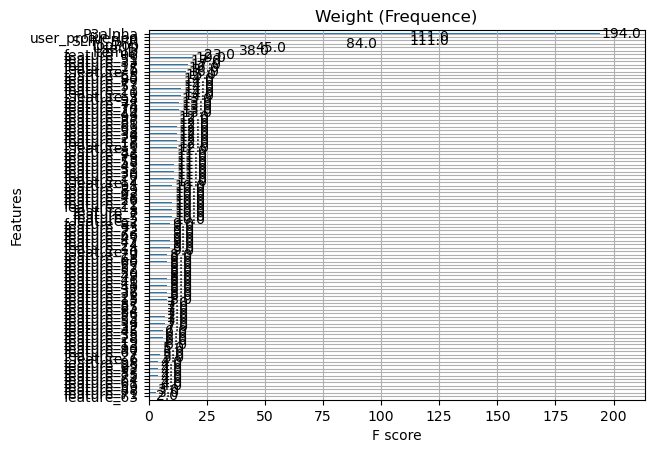

In [34]:
from xgboost import plot_importance
plot_importance(XGB_model, importance_type="weight", title="Weight (Frequence)")

### Note, here ItemID and UserID are provided as integers, meaning that XGBoost will use them as any integer number and may split user groups according to whether their ID is < or > of a certain value. This makes no sense of course because the IDs are not ordinal, they are categorical and the specific numerical value of an IDs has no relation with the semantics of the problem. 

How to address this? 
- Use one-hot-encoded values -> drawback, the number of columns becomes very large
- Use the native "Categorical" data type -> drawback, it is still experimental and may not work very well
- Use another representation of the IDs, such as target encoding -> drawback, some further processing is needed and no teaching material is provided on this

In [35]:
X_train["UserID"] = X_train["UserID"].astype("category")
X_train["ItemID"] = X_train["ItemID"].astype("category")

In [36]:
XGB_model = XGBRanker(
    objective="rank:{}".format(objective),
    n_estimators=int(n_estimators),
    random_state=random_seed,
    learning_rate=learning_rate,
    reg_alpha=reg_alpha,
    reg_lambda=reg_lambda,
    max_depth=int(max_depth),
    max_leaves=int(max_leaves),
    grow_policy=grow_policy,
    verbosity=0,  # 2 if self.verbose else 0,
    booster=booster,
    enable_categorical=True,
    tree_method="hist",  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
)

XGB_model.fit(X_train, y_train, group=groups, verbose=True)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=True,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=0, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=50,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

In [37]:
X_to_predict = X_train[X_train["UserID"] == 10]

XGB_model.predict(X_to_predict)

array([-0.5234946 , -0.4739755 , -0.45748863, -0.5234946 , -0.13265687,
       -0.19159937, -0.24502125, -0.65233874, -0.4918907 ,  0.03691341,
       -0.4918907 , -0.29013103,  0.08875244, -0.6167394 , -0.4918907 ,
       -0.4918907 , -0.4918907 ,  0.09374926, -0.09004453,  0.02964316,
       -0.42609775, -0.42609775,  0.15392809, -0.44927838, -0.42609775,
       -0.4739755 , -0.08945404,  0.03000794, -0.4739755 , -0.53411734],
      dtype=float32)

In [38]:
X_to_predict.shape

(30, 107)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

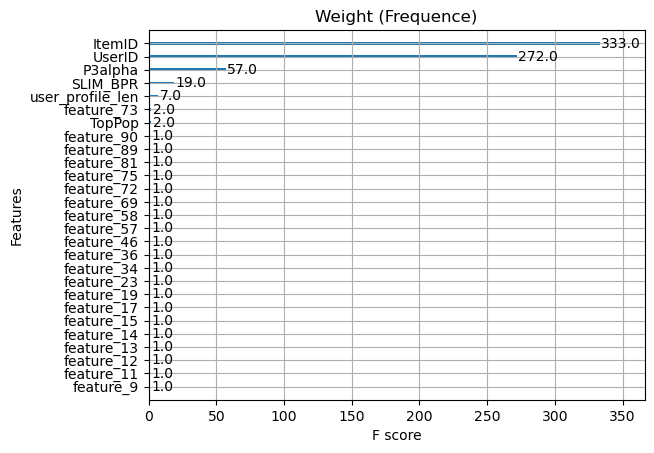

In [39]:
plot_importance(XGB_model, importance_type="weight", title="Weight (Frequence)")

In [41]:
user_id = 2

# Filter data for the user and make a copy to avoid chained assignments
X_to_predict = X_train[X_train["UserID"] == user_id].copy()

# Ensure proper encoding
X_to_predict.loc[:, "UserID"] = X_to_predict["UserID"].astype("category")
X_to_predict.loc[:, "ItemID"] = X_to_predict["ItemID"].astype("category")

# Predict scores
predicted_scores = XGB_model.predict(X_to_predict)

# Attach scores and rank items
X_to_predict.loc[:, "Score"] = predicted_scores
top_items = X_to_predict.sort_values("Score", ascending=False).head(10)

# Extract top 10 recommendations
top_10_recommendations = top_items["ItemID"].tolist()

print(f"Top 10 recommendations for User {user_id}: {top_10_recommendations}")


Top 10 recommendations for User 2: [21367, 29963, 22625, 29964, 17783, 22658, 22589, 28607, 29656, 22623]


### How to perform hyperparameter tuning?
The issue with this method is that you need a label which should be an item the user has not interacted with but that is a correct recommendation. In practice the idea is:
- Split the data in the usual training-validation-test
- Split the training data in two: one part you use to train the recommenders and another you use as the hidden Label to train XGBoost
- Evaluate your predictions on the validation data as you did for any other recommender model. Use this to select the optimal hyperparameters.
- Given the selected hyperparameters, train the recommender models on all the available data and use all the available data to compute the features used by XGBoost.

Challenge: Since the label we use for training XGBoost is the split of a split, it may happen that the actual correct recommendations are very few. This will result in a problem that is very unbalanced towards zero and will make the training difficult and the evaluation noisy. To mitigate this you may use k-fold cross validation and define the valdation result of a certain hyperparameter configuration as the average obtained with k different training-label splits.

In [42]:
def calculate_MAP(predictions, true_labels, k=10):
    """
    Compute Mean Average Precision at K (MAP@K).
    
    Parameters:
    - predictions: A list of lists, where each inner list contains the predicted item IDs for a user (ranked in descending order of relevance).
    - true_labels: A list of sets, where each set contains the ground-truth relevant item IDs for the corresponding user.
    - k: The cutoff for precision evaluation.
    
    Returns:
    - mean_ap: Mean Average Precision at K across all users.
    """
    def average_precision_at_k(predicted, actual, k):
        if len(predicted) > k:
            predicted = predicted[:k]

        score = 0.0
        num_hits = 0.0

        for i, p in enumerate(predicted):
            if p in actual and p not in predicted[:i]:  # Avoid duplicates
                num_hits += 1.0
                score += num_hits / (i + 1.0)

        if not actual:
            return 0.0

        return score / min(len(actual), k)

    # Calculate AP@K for each user
    ap_scores = [
        average_precision_at_k(pred, true, k)
        for pred, true in zip(predictions, true_labels)
    ]

    # Return the mean AP@K
    return sum(ap_scores) / len(ap_scores)


In [ ]:
print(f"Groups size: {len(groups)}")
print(f"Train indices max: {max(train_idx)}, Train indices min: {min(train_idx)}")


Groups size: 35736


NameError: name 'train_id' is not defined

In [43]:
import optuna
from sklearn.model_selection import KFold

def objective(trial):
    # Define the hyperparameter search space
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    reg_alpha = trial.suggest_float("reg_alpha", 0.0, 1.0)
    reg_lambda = trial.suggest_float("reg_lambda", 0.0, 1.0)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)

    # Initialize the XGBoost model
    model = XGBRanker(
        objective="rank:pairwise",
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
    )

    # Perform k-fold cross-validation
    kf = KFold(n_splits=5)
    scores = []

    for train_idx, val_idx in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        groups_train = groups[train_idx]
        groups_val = groups[val_idx]

        model.fit(
            X_train_fold, y_train_fold, group=groups_train, eval_metric="ndcg",
            eval_set=[(X_val_fold, y_val_fold)], verbose=False, early_stopping_rounds=10
        )
        predictions = model.predict(X_val_fold)
        score = calculate_MAP(predictions, y_val_fold)  # Replace with your metric
        scores.append(score)

    return sum(scores) / len(scores)  # Average score over k folds

# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1)

# Get the best hyperparameters
best_params = study.best_params
print("Best parameters:", best_params)


[I 2024-11-30 17:41:20,630] A new study created in memory with name: no-name-39684fa5-2445-47cd-8165-e6f77d89f93f
[W 2024-11-30 17:41:26,304] Trial 0 failed with parameters: {'learning_rate': 0.04301432960070526, 'n_estimators': 255, 'max_depth': 5, 'reg_alpha': 0.7598571788926055, 'reg_lambda': 0.9451310213936197, 'subsample': 0.7169796513890369, 'colsample_bytree': 0.7966197683184512} because of the following error: IndexError('index 214416 is out of bounds for axis 0 with size 35736').
Traceback (most recent call last):
  File "/opt/miniconda3/envs/recsys/lib/python3.9/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/t_/9cbyldyd2bv5q2656cp65pbr0000gn/T/ipykernel_51131/3091864200.py", line 33, in objective
    groups_train = groups[train_idx]
IndexError: index 214416 is out of bounds for axis 0 with size 35736
[W 2024-11-30 17:41:26,328] Trial 0 failed with value None.


IndexError: index 214416 is out of bounds for axis 0 with size 35736